# Segmenting and Clustering Neighborhoods in Toronto

## - CHECK 1: GETTING THE DATA

In [1]:
import pandas as pd
import numpy as np

- I´ve used the =ImportHTML() formula from Google Spreadsheet to download the table from wikipedia in CSV format
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [2]:
toronto=pd.read_csv('Toronto-neighborhoods.csv')
toronto.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
toronto.shape

(180, 3)

- Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [4]:
toronto[toronto['Borough']=='Not assigned'].count()

Postal Code     77
Borough         77
Neighborhood     0
dtype: int64

We have 77 rows with not assigned borough so we delete them

In [5]:
toronto.drop(toronto[toronto['Borough']=='Not assigned'].index,inplace=True)
toronto.shape

(103, 3)

In [6]:
toronto[toronto.duplicated('Postal Code')]

,Postal Code,Borough,Neighborhood


In [7]:
toronto[toronto.duplicated('Neighborhood')]

,Postal Code,Borough,Neighborhood
20,M3C,North York,Don Mills
74,M3L,North York,Downsview
83,M3M,North York,Downsview
92,M3N,North York,Downsview
109,M2R,North York,Willowdale


Confirm that we have unique Postal Codes and only 3 neighborhoods have more than one Postal Code

In [8]:
toronto[toronto['Neighborhood']=='Not assigned']

,Postal Code,Borough,Neighborhood


Confirm that we don´t have unassigned  Neighborhoods

## - CHECK 2: GETTING THE LATITUDE AND LONGITUDE COORDINATES OF EACH NEIGHBORHOODD

In [9]:
from geopy.geocoders import Nominatim

In [10]:
toronto.head(10)

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M9A,Etobicoke,Islington Avenue
9,M1B,Scarborough,"Malvern, Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill, Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


New Dataframe to store the latitude and longitude of each neighborhood

In [11]:
# define the dataframe columns
column_names = ['Latitude', 'Longitude'] 

# instantiate the dataframe
coordinates = pd.DataFrame(columns=column_names)
coordinates

,Latitude,Longitude


In [12]:
import geocoder
#for i in toronto['Postal Code']:
for len in range(0,103):
    g = geocoder.arcgis(toronto.iloc[len,0])
    lat_lng_coords = g.latlng
    coordinates = coordinates.append({'Latitude': lat_lng_coords[0],
                               'Longitude': lat_lng_coords[1]}, ignore_index=True)
    
coordinates
    

,Latitude,Longitude
0,43.752935,-79.335641
1,43.728102,-79.311890
2,43.650964,-79.353041
3,43.723265,-79.451211
4,43.661790,-79.389390
...,...,...
98,43.653340,-79.509766
99,43.666659,-79.381472
100,43.648700,-79.385450
101,43.632798,-79.493017


In [13]:
print(toronto.shape)
print(coordinates.shape)

(103, 3)
(103, 2)


- Concat the two Dataframes

In [14]:
toronto.index = range(toronto.shape[0])
toronto=pd.concat([toronto,coordinates], axis=1)

In [15]:
toronto

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.752935,-79.335641
1,M4A,North York,Victoria Village,43.728102,-79.311890
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650964,-79.353041
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.723265,-79.451211
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.661790,-79.389390
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653340,-79.509766
99,M4Y,Downtown Toronto,Church and Wellesley,43.666659,-79.381472
100,M7Y,East Toronto,Business reply mail Processing Centre,43.648700,-79.385450
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.632798,-79.493017


## - CHECK 3: EXPLORE AND CLUSTER THE NEIGHBORHOODS IN TORONTO

In [16]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

#### Create a map of Toronto with neighborhoods superimposed on top.

In [17]:
address = 'Toronto, Canada'
geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

# create map of Toronto using latitude and longitude values
map_toronto= folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto['Latitude'], toronto['Longitude'],
                                           toronto['Borough'], toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [18]:
toronto.Borough.value_counts()

North York          24
Downtown Toronto    19
Scarborough         17
Etobicoke           12
Central Toronto      9
West Toronto         6
East Toronto         5
East York            5
York                 5
Mississauga          1
Name: Borough, dtype: int64

In order to simplify the analysis, let´s segment and cluster only the neighborhoods that contain the word Toronto. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [19]:
toronto_data=toronto[toronto['Borough'].str.contains("Toronto")]
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650964,-79.353041
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.661790,-79.389390
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657491,-79.377529
15,M5C,Downtown Toronto,St. James Town,43.651734,-79.375554
19,M4E,East Toronto,The Beaches,43.678148,-79.295349


In [20]:
toronto_data.shape

(39, 5)

### Create a map of Toronto with neighborhoods superimposed on top

In [39]:
address = 'Downtown Toronto, Toronto'
geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

# create map of Toronto using latitude and longitude values
map_toronto= folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'],
                                           toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The geograpical coordinate of Toronto City are 43.6541737, -79.38081164513409.


#### Define Foursquare Credentials and Version

In [22]:
CLIENT_ID = 'ZCQ3RYENJGMFREJ1JEZJBICC1OHM41LXGPCIEBVSANGBQ5GT' 
CLIENT_SECRET = '02114VXQCT0NHAUKBHGTR2P30LAU32EMICVAAF1VZ2HNIWQ5'
VERSION = '20180605' 

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: ZCQ3RYENJGMFREJ1JEZJBICC1OHM41LXGPCIEBVSANGBQ5GT
CLIENT_SECRET:02114VXQCT0NHAUKBHGTR2P30LAU32EMICVAAF1VZ2HNIWQ5


#### Let's get the top 100 venues of each Neighborhood

In [23]:
radius = 500
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
toronto_venues= getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst 
Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town

In [25]:
print(toronto_venues.shape)
toronto_venues.head()

(1591, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.650964,-79.353041,Souk Tabule,43.653756,-79.354390,Mediterranean Restaurant
1,"Regent Park, Harbourfront",43.650964,-79.353041,Young Centre for the Performing Arts,43.650825,-79.357593,Performing Arts Venue
2,"Regent Park, Harbourfront",43.650964,-79.353041,SOMA chocolatemaker,43.650622,-79.358127,Chocolate Shop
3,"Regent Park, Harbourfront",43.650964,-79.353041,BATLgrounds,43.647088,-79.351306,Athletics & Sports
4,"Regent Park, Harbourfront",43.650964,-79.353041,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant


- ¿How many venues were returned for each neighborhood?

In [26]:
toronto_venues.groupby('Neighborhood')['Venue'].count().sort_values(ascending=False)

Neighborhood
Business reply mail Processing Centre                                                                           100
Stn A PO Boxes                                                                                                  100
Commerce Court, Victoria Hotel                                                                                  100
First Canadian Place, Underground city                                                                          100
Richmond, Adelaide, King                                                                                        100
Garden District, Ryerson                                                                                        100
Toronto Dominion Centre, Design Exchange                                                                        100
Church and Wellesley                                                                                             84
St. James Town                                             

### LET´S ANALYZE EACH NEIGHBORHOOD

In [27]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot


,Yoga Studio,Accessories Store,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1587,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1588,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1589,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###  Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [28]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,Berczy Park,0.015152,0.000000,0.0,0.00,0.015152,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.015152,0.000000,0.000000,0.00,0.0,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.023256,0.0,0.00,0.023256,0.000000,0.023256,0.000000,0.0,...,0.023256,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0
2,Business reply mail Processing Centre,0.000000,0.000000,0.0,0.02,0.010000,0.000000,0.000000,0.030000,0.0,...,0.000000,0.0,0.0,0.0,0.020000,0.000000,0.000000,0.01,0.0,0.0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.015152,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.0,0.0
4,Central Bay Street,0.000000,0.000000,0.0,0.00,0.000000,0.019608,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.019608,0.019608,0.00,0.0,0.0


In [29]:
toronto_grouped.shape

(39, 218)

#### Let's print each neighborhood along with the top 5 most common venues

In [30]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1  Seafood Restaurant  0.05
2        Cocktail Bar  0.05
3      Breakfast Spot  0.03
4          Restaurant  0.03


----Brockton, Parkdale Village, Exhibition Place----
                    venue  freq
0                    Café  0.07
1             Coffee Shop  0.07
2              Restaurant  0.05
3               Gift Shop  0.05
4  Thrift / Vintage Store  0.05


----Business reply mail Processing Centre----
                 venue  freq
0          Coffee Shop  0.07
1                Hotel  0.05
2                 Café  0.04
3           Restaurant  0.04
4  Japanese Restaurant  0.04


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst 
Quay, South Niagara, Island airport----
               venue  freq
0               Park  0.06
1               Café  0.06
2        Coffee Shop  0.06
3  French Restaurant  0.05
4         Restaurant  0.05


----Central Bay Street----
                 venue  freq
0    

#### Let's put that into a *pandas* dataframe

- Function to sort the venues in descending order.

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

- Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Seafood Restaurant,Cocktail Bar,Café,Hotel,Restaurant,Cheese Shop,Breakfast Spot,Beer Bar,Bakery
1,"Brockton, Parkdale Village, Exhibition Place",Coffee Shop,Café,Restaurant,Gift Shop,Thrift / Vintage Store,Pet Store,Boutique,French Restaurant,Brewery,Italian Restaurant
2,Business reply mail Processing Centre,Coffee Shop,Hotel,Restaurant,Japanese Restaurant,Café,Asian Restaurant,Thai Restaurant,Gym,Steakhouse,Sushi Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Park,Café,Coffee Shop,Restaurant,French Restaurant,Spa,Lounge,Bar,Speakeasy,Japanese Restaurant
4,Central Bay Street,Coffee Shop,Sandwich Place,Clothing Store,Middle Eastern Restaurant,Japanese Restaurant,Bubble Tea Shop,Plaza,Restaurant,Fast Food Restaurant,Poke Place


## CLUSTER NEIGHBORHOODS

Let´s Run *k*-means to cluster the neighborhoods 

- We are going to calculate the idoneous number of clusters based on the elbow method



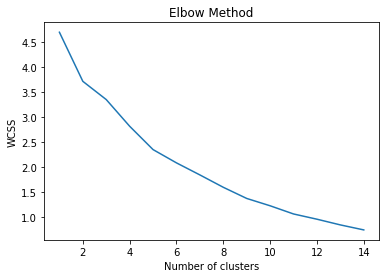

In [34]:
#K-Means Performing. Elbow Method
import matplotlib.pyplot as plt
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(toronto_grouped_clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Let´s try with 5 clusters

In [35]:
# set number of clusters
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 0, 2, 2, 2, 2])

In [36]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() 

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.650964,-79.353041,2,Pub,Café,Athletics & Sports,Mediterranean Restaurant,Theater,French Restaurant,Distribution Center,Coffee Shop,Bank,Tech Startup
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.661790,-79.389390,2,Coffee Shop,Café,Sushi Restaurant,Yoga Studio,Creperie,Burrito Place,Sandwich Place,College Auditorium,Park,Distribution Center
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657491,-79.377529,2,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Sandwich Place,Bar,Restaurant,Café,Movie Theater,Italian Restaurant,Hotel
15,M5C,Downtown Toronto,St. James Town,43.651734,-79.375554,2,Café,Coffee Shop,Cocktail Bar,American Restaurant,Seafood Restaurant,Gastropub,Cosmetics Shop,Creperie,Italian Restaurant,Gym
19,M4E,East Toronto,The Beaches,43.678148,-79.295349,2,Health Food Store,Trail,Coffee Shop,Pub,Church,Park,Cuban Restaurant,Dog Run,Fish & Chips Shop,Fast Food Restaurant


In [37]:
toronto_merged.groupby('Cluster Labels').count()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,
0,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31
3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Examining the resulting clusters

### CLUSTER 1

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0,
                     toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Downtown Toronto,0,Café,Grocery Store,Coffee Shop,Baby Store,Candy Store,Athletics & Sports,Playground,Park,Farm,Donut Shop
31,West Toronto,0,Furniture / Home Store,Park,Grocery Store,Athletics & Sports,Bus Line,Brazilian Restaurant,Bank,Bakery,Pool,Pet Store
41,East Toronto,0,Park,Bus Line,Grocery Store,Business Service,Discount Store,Women's Store,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Fast Food Restaurant
73,Central Toronto,0,Playground,Gym Pool,Park,Garden,Distribution Center,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
91,Downtown Toronto,0,Playground,Grocery Store,Park,Candy Store,Distribution Center,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


### CLUSTER 2

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1,
                     toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,Central Toronto,1,Furniture / Home Store,Women's Store,Dog Run,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant


### CLUSTER 3

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2,
                     toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,2,Pub,Café,Athletics & Sports,Mediterranean Restaurant,Theater,French Restaurant,Distribution Center,Coffee Shop,Bank,Tech Startup
4,Downtown Toronto,2,Coffee Shop,Café,Sushi Restaurant,Yoga Studio,Creperie,Burrito Place,Sandwich Place,College Auditorium,Park,Distribution Center
9,Downtown Toronto,2,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Sandwich Place,Bar,Restaurant,Café,Movie Theater,Italian Restaurant,Hotel
15,Downtown Toronto,2,Café,Coffee Shop,Cocktail Bar,American Restaurant,Seafood Restaurant,Gastropub,Cosmetics Shop,Creperie,Italian Restaurant,Gym
19,East Toronto,2,Health Food Store,Trail,Coffee Shop,Pub,Church,Park,Cuban Restaurant,Dog Run,Fish & Chips Shop,Fast Food Restaurant
20,Downtown Toronto,2,Coffee Shop,Seafood Restaurant,Cocktail Bar,Café,Hotel,Restaurant,Cheese Shop,Breakfast Spot,Beer Bar,Bakery
24,Downtown Toronto,2,Coffee Shop,Sandwich Place,Clothing Store,Middle Eastern Restaurant,Japanese Restaurant,Bubble Tea Shop,Plaza,Restaurant,Fast Food Restaurant,Poke Place
30,Downtown Toronto,2,Coffee Shop,Café,Clothing Store,Restaurant,Thai Restaurant,Sushi Restaurant,Salad Place,Deli / Bodega,Gym,Hotel
36,Downtown Toronto,2,Harbor / Marina,Theme Park,Fast Food Restaurant,Farm,Park,Women's Store,Distribution Center,Fish & Chips Shop,Farmers Market,Falafel Restaurant
37,West Toronto,2,Bar,Cocktail Bar,Restaurant,Wine Bar,Vietnamese Restaurant,Coffee Shop,Asian Restaurant,Yoga Studio,Seafood Restaurant,Italian Restaurant


### CLUSTER 4

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3,
                     toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
61,Central Toronto,3,Swim School,Bus Line,Women's Store,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm


### CLUSTER 5

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4,
                     toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
62,Central Toronto,4,Spa,IT Services,Women's Store,Dog Run,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
